In [41]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [47]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [61]:
dataset = datasets.ImageFolder(root='archive/data', transform=image_transforms)

In [62]:
class_names = dataset.classes
class_names 

['with_mask', 'without_mask']

In [63]:
num_classes = len(dataset.classes)
num_classes

2

In [64]:

train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(5664, 1889)

In [65]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [66]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [67]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.5528543].


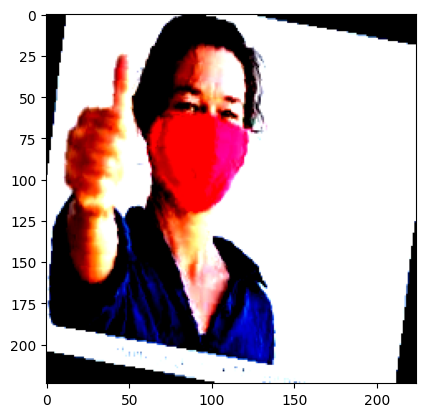

In [68]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

In [70]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x

In [71]:
images.size(0)

32

In [72]:
len(train_loader.dataset)


5664

In [73]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [77]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 0.70
Batch: 20, Epoch: 1, Loss: 0.64
Batch: 30, Epoch: 1, Loss: 0.51
Batch: 40, Epoch: 1, Loss: 0.55
Batch: 50, Epoch: 1, Loss: 0.46
Batch: 60, Epoch: 1, Loss: 0.31
Batch: 70, Epoch: 1, Loss: 0.16
Batch: 80, Epoch: 1, Loss: 0.25
Batch: 90, Epoch: 1, Loss: 0.27
Batch: 100, Epoch: 1, Loss: 0.40
Batch: 110, Epoch: 1, Loss: 0.41


C:\Users\M.Zaid Naeem\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Batch: 120, Epoch: 1, Loss: 0.46
Batch: 130, Epoch: 1, Loss: 0.27
Batch: 140, Epoch: 1, Loss: 0.21
Batch: 150, Epoch: 1, Loss: 0.47
Batch: 160, Epoch: 1, Loss: 0.27
Batch: 170, Epoch: 1, Loss: 0.47
Epoch [1/10], Avg Loss: 0.4836
*** Validation Accuracy: 87.19% ***
Batch: 10, Epoch: 2, Loss: 0.15
Batch: 20, Epoch: 2, Loss: 0.35
Batch: 30, Epoch: 2, Loss: 0.28
Batch: 40, Epoch: 2, Loss: 0.44
Batch: 50, Epoch: 2, Loss: 0.29
Batch: 60, Epoch: 2, Loss: 0.23
Batch: 70, Epoch: 2, Loss: 0.18
Batch: 80, Epoch: 2, Loss: 0.32
Batch: 90, Epoch: 2, Loss: 0.24
Batch: 100, Epoch: 2, Loss: 0.13
Batch: 110, Epoch: 2, Loss: 0.38
Batch: 120, Epoch: 2, Loss: 0.28
Batch: 130, Epoch: 2, Loss: 0.36
Batch: 140, Epoch: 2, Loss: 0.27
Batch: 150, Epoch: 2, Loss: 0.21
Batch: 160, Epoch: 2, Loss: 0.13
Batch: 170, Epoch: 2, Loss: 0.25
Epoch [2/10], Avg Loss: 0.2652
*** Validation Accuracy: 87.72% ***
Batch: 10, Epoch: 3, Loss: 0.35
Batch: 20, Epoch: 3, Loss: 0.19
Batch: 30, Epoch: 3, Loss: 0.16
Batch: 40, Epoch: 3,

In [80]:
torch.save(model.state_dict(), 'face_detection_model.pth')

In [81]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       934
           1       0.95      0.94      0.95       955

    accuracy                           0.94      1889
   macro avg       0.94      0.94      0.94      1889
weighted avg       0.95      0.94      0.94      1889



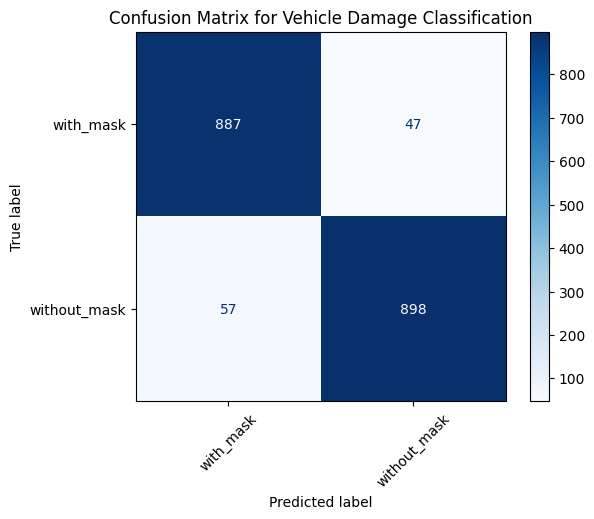

In [82]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()